# Prétraitement et Analyse d'Images Médicales

Ce notebook présente un pipeline complet combinant deux approches :

- **Une approche de prétraitement statique** destinée à lire, normaliser, filtrer, améliorer le contraste, redimensionner et sauvegarder une image médicale (ex : DICOM).
- **Une interface interactive** basée sur des widgets Jupyter pour sélectionner et appliquer différentes opérations de prétraitement et d'analyse.

Chaque étape est expliquée en détail ci-dessous.

## 0. Executez cette cellule pour installer les packages prérequis  

In [8]:
!pip install pydicom numpy scikit-image opencv-python matplotlib Pillow ipywidgets scikit-learn

Acc�s refus�.


In [9]:
import pydicom
import numpy as np
import cv2
from skimage.filters import median
from skimage.transform import resize
from skimage.exposure import equalize_adapthist
import matplotlib.pyplot as plt
from pydicom.pixel_data_handlers.util import apply_modality_lut
from PIL import Image
import ipywidgets as widgets
from IPython.display import display, clear_output

import os, tempfile

## 1. Fonctions Utilitaires pour le Prétraitement

Les fonctions suivantes permettent d'effectuer différentes opérations sur une image médicale :

- **Chargement** : Lecture d'un fichier image (DICOM ou format standard) et extraction des métadonnées.
- **Normalisation** : Ajustement de l'échelle des pixels pour uniformiser les valeurs.
- **Réduction du bruit** : Utilisation d'un filtre médian pour diminuer le bruit de l'image.
- **Amélioration du contraste** : Application d'une égalisation d'histogramme pour mettre en évidence les détails.
- **Redimensionnement** : Adaptation de la taille de l'image à une dimension cible.
- **Sauvegarde** : Enregistrement de l'image prétraitée en format NumPy.

In [10]:
##############################################
# Définition des fonctions de prétraitement
##############################################

def load_image(filepath):
    """Charge une image à partir d'un fichier. Supporte DICOM et formats standard."""
    if filepath.lower().endswith(('.dcm', '.dicom')):
        ds = pydicom.dcmread(filepath)
        # Appliquer la LUT pour transformer les pixels
        image = apply_modality_lut(ds.pixel_array, ds)
        metadata = {
            "Patient ID": getattr(ds, "PatientID", "Non disponible"),
            "Modality": getattr(ds, "Modality", "Non disponible"),
            "Study Date": getattr(ds, "StudyDate", "Non disponible"),
            "Dimensions": f"{ds.pixel_array.shape[0]} x {ds.pixel_array.shape[1]}"
        }
    else:
        # Ouvrir avec PIL et convertir en array numpy
        image = np.array(Image.open(filepath))
        metadata = {}
    return image, metadata

def normalize_image(image):
    """Normalise l'image pour que ses valeurs soient entre 0 et 1 ou 0 et 255 selon le contexte."""
    if image.dtype == np.uint8:
        norm_img = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
    else:
        norm_img = (image - np.min(image)) / (np.max(image) - np.min(image))
    return norm_img

def denoise_image(image, kernel_size=3):
    """Applique un filtre médian pour réduire le bruit."""
    if kernel_size % 2 == 0:
        kernel_size += 1
    denoised = cv2.medianBlur(image, kernel_size)
    return denoised

def enhance_contrast(image):
    """Améliore le contraste de l'image en utilisant l'égalisation d'histogramme (en niveaux de gris)."""
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image
    enhanced = cv2.equalizeHist(gray)
    return enhanced

def resize_image(image, target_size=(256, 256)):
    """Redimensionne l'image à la taille cible en utilisant une interpolation anti-aliasing."""
    if len(image.shape) == 3 and image.shape[2] > 1:
        # Redimensionnement canal par canal
        resized = np.zeros((target_size[0], target_size[1], image.shape[2]), dtype=image.dtype)
        for c in range(image.shape[2]):
            resized[:,:,c] = (resize(image[:,:,c], target_size, anti_aliasing=True) * 255).astype(np.uint8)
    else:
        resized = (resize(image, target_size, anti_aliasing=True) * 255).astype(np.uint8)
    return resized

def save_processed_image(image, filename='processed_image.npy'):
    """Sauvegarde l'image prétraitée au format NumPy."""
    np.save(filename, image)
    print(f"Image sauvegardée sous {filename}")

## 2. Interface Interactive pour le Prétraitement

Cette section fournit une interface utilisateur avec des widgets permettant de :

- Choisir un fichier à uploader ou utiliser une image d'exemple.
- Sélectionner les opérations de prétraitement à appliquer : normalisation, réduction du bruit, amélioration du contraste et redimensionnement.
- Régler les paramètres (taille du noyau pour le filtre médian, taille cible de redimensionnement) via des sliders.
- Lancer le prétraitement et visualiser successivement l'image originale et l'image prétraitée.

Ces options offrent une grande flexibilité pour ajuster le pipeline selon les besoins de l'analyse.

Button(description='Lancer le prétraitement', style=ButtonStyle())

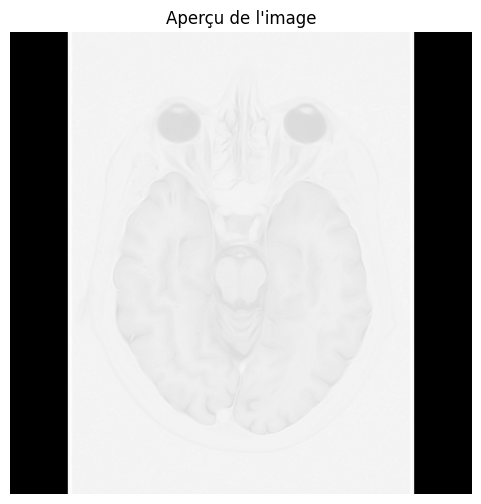

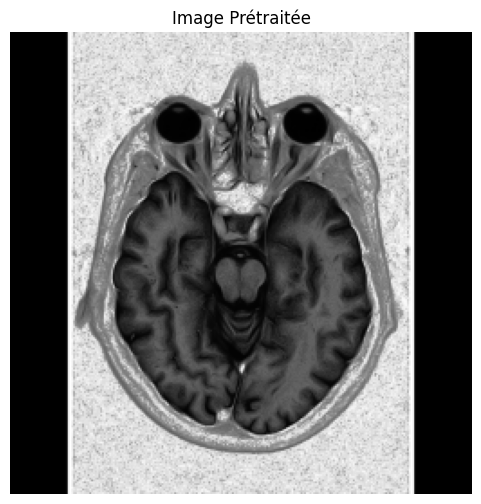

In [ ]:
##############################################
# Interface interactive avec ipywidgets
##############################################

# Widgets pour uploader un fichier ou utiliser une image d'exemple
upload_widget = widgets.FileUpload(
    accept='.png,.jpg,.jpeg,.dcm,.dicom', 
    multiple=False, 
    description="Uploader"
)
example_checkbox = widgets.Checkbox(value=False, description="Utiliser image d'exemple")
example_dropdown = widgets.Dropdown(
    options=["Radiographie pulmonaire", "IRM cérébrale", "Échographie", "Tomographie", "Mammographie"],
    value="IRM cérébrale",
    description="Type d'exemple:"
)

# Widgets pour choisir les opérations de prétraitement
norm_chk    = widgets.Checkbox(value=True, description="Normalisation")
denoise_chk = widgets.Checkbox(value=True, description="Réduction du bruit")
contrast_chk= widgets.Checkbox(value=True, description="Amélioration du contraste")
resize_chk  = widgets.Checkbox(value=True, description="Redimensionnement")

kernel_slider  = widgets.IntSlider(value=3, min=3, max=15, step=2, description='Taille noyau')
size_slider    = widgets.IntSlider(value=256, min=64, max=512, step=32, description='Taille cible')

# Bouton de lancement de prétraitement
process_button = widgets.Button(description="Lancer le prétraitement")

# Affichage initial des widgets
display(widgets.HBox([upload_widget, example_checkbox, example_dropdown]))
display(widgets.HBox([norm_chk, denoise_chk, contrast_chk, resize_chk]))
display(widgets.HBox([kernel_slider, size_slider]))
display(process_button)

## 3. Application du Prétraitement

La fonction `process_image(image)` applique successivement les opérations de prétraitement selon les options choisies :

- **Normalisation** : Ajuste l'échelle des pixels. Si l'image est en `float`, elle est reconvertie en `uint8` pour les opérations suivantes.
- **Réduction du bruit** : Applique un filtre médian en utilisant la taille du noyau indiquée par le slider.
- **Amélioration du contraste** : Transforme l'image en niveaux de gris puis applique l'égalisation d'histogramme.
- **Redimensionnement** : Modifie les dimensions de l'image pour atteindre la taille cible spécifiée.

Chaque opération est conditionnelle (activée via une case à cocher).

In [12]:
##############################################
# Fonction de prétraitement appliquée à l'image
##############################################

def process_image(image):
    proc_image = image.copy()

    # Si image est 3D volumique, on prend une slice centrale
    if proc_image.ndim == 3 and proc_image.shape[2] not in [3, 4]:
        slice_index = proc_image.shape[0] // 2
        proc_image = proc_image[slice_index]

    # Appliquer les traitements en fonction des cases cochées
    if norm_chk.value:
        proc_image = normalize_image(proc_image)
        # Si normalisation en [0, 1], ramener en [0, 255] pour affichage / OpenCV
        if proc_image.max() <= 1.0:
            proc_image = (proc_image * 255).astype(np.uint8)
        elif proc_image.dtype != np.uint8:
            proc_image = proc_image.astype(np.uint8)

    if denoise_chk.value:
        proc_image = denoise_image(proc_image, kernel_size=kernel_slider.value)

    if contrast_chk.value:
        proc_image = enhance_contrast(proc_image)

    if resize_chk.value:
        proc_image = resize_image(proc_image, target_size=(size_slider.value, size_slider.value))

    return proc_image


## 4. Gestion du Fichier Uploadé et Image d'Exemple

La fonction `get_input_image()` retourne l'image, les métadonnées et le nom du fichier en fonction de l'option utilisée :

- **Image d'exemple** : Une image aléatoire (pour simuler une image médicale) avec des informations de base.
- **Fichier uploadé** : Le fichier téléversé est sauvegardé temporairement via le module `tempfile` puis chargé avec la fonction `load_image`.

In [13]:
##############################################
# Gestion du fichier uploadé et image d'exemple
##############################################

def get_input_image():
    """
    Retourne (image, metadata, filename) en fonction de l'option d'image d'exemple 
    ou du fichier uploadé.
    """
    if example_checkbox.value:
        # Génère une image exemple aléatoire
        image = np.random.randint(0, 256, (512, 512), dtype=np.uint8)
        metadata = {"Type": example_dropdown.value, "Dimensions": "512x512"}
        filename = f"exemple_{example_dropdown.value.replace(' ', '_')}.png"
    else:
        if upload_widget.value:
            # Gérer la structure selon le widget (dictionnaire ou tuple)
            if isinstance(upload_widget.value, dict):
                file_info = next(iter(upload_widget.value.values()))
            elif isinstance(upload_widget.value, tuple):
                file_info = upload_widget.value[0]
            else:
                file_info = None
            if file_info is not None:
                content = file_info['content']
                filename = file_info.get('metadata', {}).get('name', None)
                if filename is None:
                    filename = file_info.get('name', 'uploaded_file')
                # Utilisation d'un fichier temporaire pour le téléchargement
                temp_file = tempfile.NamedTemporaryFile(delete=False, suffix=os.path.splitext(filename)[1])
                temp_file.write(content)
                temp_file.close()
                image, metadata = load_image(temp_file.name)
                # Conserver le nom temporaire pour référence
                filename = temp_file.name
            else:
                image, metadata, filename = None, {}, None
        else:
            image, metadata, filename = None, {}, None
    return image, metadata, filename

## 5. Exécution du Pipeline

La fonction callback `on_process_clicked(b)` est déclenchée par le bouton "Lancer le prétraitement". Elle effectue les actions suivantes :

1. **Réaffichage** de l'interface utilisateur (widgets) pour garder la cohérence de l'affichage.
2. **Récupération** de l'image via `get_input_image()` (soit par upload soit par l'exemple).
3. **Affichage** de l'image originale avec ses métadonnées.
4. **Application** de la fonction de prétraitement `process_image(image)` sur l'image d'entrée.
5. **Affichage** de l'image prétraitée.
6. **Sauvegarde** de l'image prétraitée avec `save_processed_image`.

Ainsi, vous pouvez visualiser chaque étape du traitement directement dans le Notebook.

In [14]:
##############################################
# Callback pour déclencher le prétraitement et affichage
##############################################

def on_process_clicked(b):
    clear_output(wait=True)
    # Réaffichage des widgets
    display(widgets.HBox([upload_widget, example_checkbox, example_dropdown]))
    display(widgets.HBox([norm_chk, denoise_chk, contrast_chk, resize_chk]))
    display(widgets.HBox([kernel_slider, size_slider]))
    display(process_button)
    
    # Récupérer l'image d'entrée
    image, metadata, filename = get_input_image()
    if image is None:
        print("Aucune image chargée.")
        return
    
    # Affichage de l'image originale
    print("Image originale :", filename)
    plt.figure(figsize=(6,6))
    # Si l’image est 3D (volumique), on prend une slice
    if len(image.shape) == 3 and image.shape[2] not in [3, 4]:
        slice_index = image.shape[0] // 2
        image_to_display = image[slice_index]
        cmap = "gray"
    elif len(image.shape) == 2:
        image_to_display = image
        cmap = "gray"
    else:
        image_to_display = image
        cmap = None

    plt.imshow(image_to_display, cmap=cmap)
    plt.title("Aperçu de l'image")
    plt.axis("off")
    plt.show()
    
    # Application des prétraitements
    proc_image = process_image(image)
    
    # Affichage de l'image prétraitée
    print("Image prétraitée :")
    plt.figure(figsize=(6,6))
    plt.imshow(proc_image, cmap="gray")
    plt.title("Image Prétraitée")
    plt.axis("off")
    plt.show()
    
    # Sauvegarde de l'image prétraitée
    # save_processed_image(proc_image, filename="processed_image.npy")

process_button.on_click(on_process_clicked)

##### <b><center>By Kamal & Ranya<center/><b/>